# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 18:36 - loss: 0.6933

  32/1875 [..............................] - ETA: 2s - loss: 0.5322   

  64/1875 [>.............................] - ETA: 2s - loss: 0.4538

  97/1875 [>.............................] - ETA: 2s - loss: 0.4121

 130/1875 [=>............................] - ETA: 2s - loss: 0.3856

 163/1875 [=>............................] - ETA: 2s - loss: 0.3665

 194/1875 [==>...........................] - ETA: 2s - loss: 0.3523

 226/1875 [==>...........................] - ETA: 2s - loss: 0.3402

 259/1875 [===>..........................] - ETA: 2s - loss: 0.3296

 292/1875 [===>..........................] - ETA: 2s - loss: 0.3205

 324/1875 [====>.........................] - ETA: 2s - loss: 0.3128

 358/1875 [====>.........................] - ETA: 2s - loss: 0.3055

 391/1875 [=====>........................] - ETA: 2s - loss: 0.2991

 425/1875 [=====>........................] - ETA: 2s - loss: 0.2931

 460/1875 [======>.......................] - ETA: 2s - loss: 0.2876

 488/1875 [======>.......................] - ETA: 2s - loss: 0.2835

 519/1875 [=======>......................] - ETA: 2s - loss: 0.2793

 548/1875 [=======>......................] - ETA: 2s - loss: 0.2756

 578/1875 [========>.....................] - ETA: 2s - loss: 0.2720

 611/1875 [========>.....................] - ETA: 1s - loss: 0.2683

 636/1875 [=========>....................] - ETA: 1s - loss: 0.2657

 668/1875 [=========>....................] - ETA: 1s - loss: 0.2624

 697/1875 [==========>...................] - ETA: 1s - loss: 0.2597

 727/1875 [==========>...................] - ETA: 1s - loss: 0.2569

 755/1875 [===========>..................] - ETA: 1s - loss: 0.2545

 783/1875 [===========>..................] - ETA: 1s - loss: 0.2522

 813/1875 [============>.................] - ETA: 1s - loss: 0.2498

 843/1875 [============>.................] - ETA: 1s - loss: 0.2475

 871/1875 [============>.................] - ETA: 1s - loss: 0.2455

 896/1875 [=============>................] - ETA: 1s - loss: 0.2437

 924/1875 [=============>................] - ETA: 1s - loss: 0.2418

 954/1875 [==============>...............] - ETA: 1s - loss: 0.2399

 984/1875 [==============>...............] - ETA: 1s - loss: 0.2380

1012/1875 [===============>..............] - ETA: 1s - loss: 0.2363

1036/1875 [===============>..............] - ETA: 1s - loss: 0.2349

1068/1875 [================>.............] - ETA: 1s - loss: 0.2330

1099/1875 [================>.............] - ETA: 1s - loss: 0.2313

1128/1875 [=================>............] - ETA: 1s - loss: 0.2298

1157/1875 [=================>............] - ETA: 1s - loss: 0.2283

1182/1875 [=================>............] - ETA: 1s - loss: 0.2270

1211/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2244

1263/1875 [===================>..........] - ETA: 1s - loss: 0.2232

1295/1875 [===================>..........] - ETA: 0s - loss: 0.2218

1322/1875 [====================>.........] - ETA: 0s - loss: 0.2206

1355/1875 [====================>.........] - ETA: 0s - loss: 0.2192

1388/1875 [=====================>........] - ETA: 0s - loss: 0.2178

1420/1875 [=====================>........] - ETA: 0s - loss: 0.2165

1444/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1476/1875 [======================>.......] - ETA: 0s - loss: 0.2144

1509/1875 [=======================>......] - ETA: 0s - loss: 0.2132

1543/1875 [=======================>......] - ETA: 0s - loss: 0.2119

1577/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1611/1875 [========================>.....] - ETA: 0s - loss: 0.2096

1645/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2074

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1750/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1810/1875 [===========================>..] - ETA: 0s - loss: 0.2034

1844/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2015


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1143

  35/1875 [..............................] - ETA: 2s - loss: 0.1114

  69/1875 [>.............................] - ETA: 2s - loss: 0.1105

 100/1875 [>.............................] - ETA: 2s - loss: 0.1103

 134/1875 [=>............................] - ETA: 2s - loss: 0.1100

 167/1875 [=>............................] - ETA: 2s - loss: 0.1098

 200/1875 [==>...........................] - ETA: 2s - loss: 0.1096

 233/1875 [==>...........................] - ETA: 2s - loss: 0.1094

 266/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 299/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 331/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 364/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 431/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 466/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 501/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 534/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 568/1875 [========>.....................] - ETA: 1s - loss: 0.1084

 602/1875 [========>.....................] - ETA: 1s - loss: 0.1083

 637/1875 [=========>....................] - ETA: 1s - loss: 0.1082

 665/1875 [=========>....................] - ETA: 1s - loss: 0.1082

 695/1875 [==========>...................] - ETA: 1s - loss: 0.1081

 726/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 757/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 786/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 812/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 836/1875 [============>.................] - ETA: 1s - loss: 0.1077

 864/1875 [============>.................] - ETA: 1s - loss: 0.1077

 892/1875 [=============>................] - ETA: 1s - loss: 0.1076

 921/1875 [=============>................] - ETA: 1s - loss: 0.1075

 949/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1004/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1034/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1063/1875 [================>.............] - ETA: 1s - loss: 0.1072

1091/1875 [================>.............] - ETA: 1s - loss: 0.1072

1116/1875 [================>.............] - ETA: 1s - loss: 0.1071

1146/1875 [=================>............] - ETA: 1s - loss: 0.1071

1175/1875 [=================>............] - ETA: 1s - loss: 0.1070

1203/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1232/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1259/1875 [===================>..........] - ETA: 1s - loss: 0.1068

1287/1875 [===================>..........] - ETA: 0s - loss: 0.1067

1316/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1345/1875 [====================>.........] - ETA: 0s - loss: 0.1066

1371/1875 [====================>.........] - ETA: 0s - loss: 0.1066

1400/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1430/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1457/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1487/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1511/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1538/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1560/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1584/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1608/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1629/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1658/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1685/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1719/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1752/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1819/1875 [============================>.] - ETA: 0s - loss: 0.1057

1853/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1057


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0904

  35/1875 [..............................] - ETA: 2s - loss: 0.0971

  70/1875 [>.............................] - ETA: 2s - loss: 0.0975

 107/1875 [>.............................] - ETA: 2s - loss: 0.0977

 146/1875 [=>............................] - ETA: 2s - loss: 0.0978

 184/1875 [=>............................] - ETA: 2s - loss: 0.0980

 219/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0981

 284/1875 [===>..........................] - ETA: 2s - loss: 0.0981

 317/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 520/1875 [=======>......................] - ETA: 1s - loss: 0.0980

 554/1875 [=======>......................] - ETA: 1s - loss: 0.0980

 588/1875 [========>.....................] - ETA: 1s - loss: 0.0980

 622/1875 [========>.....................] - ETA: 1s - loss: 0.0980

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 760/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 793/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 827/1875 [============>.................] - ETA: 1s - loss: 0.0980

 861/1875 [============>.................] - ETA: 1s - loss: 0.0980

 899/1875 [=============>................] - ETA: 1s - loss: 0.0980

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1004/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1075/1875 [================>.............] - ETA: 1s - loss: 0.0979

1108/1875 [================>.............] - ETA: 1s - loss: 0.0979

1143/1875 [=================>............] - ETA: 1s - loss: 0.0979

1178/1875 [=================>............] - ETA: 1s - loss: 0.0978

1218/1875 [==================>...........] - ETA: 0s - loss: 0.0978

1254/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1289/1875 [===================>..........] - ETA: 0s - loss: 0.0978

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1814/1875 [============================>.] - ETA: 0s - loss: 0.0976

1851/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0917

  36/1875 [..............................] - ETA: 2s - loss: 0.0953

  69/1875 [>.............................] - ETA: 2s - loss: 0.0954

 105/1875 [>.............................] - ETA: 2s - loss: 0.0955

 144/1875 [=>............................] - ETA: 2s - loss: 0.0956

 181/1875 [=>............................] - ETA: 2s - loss: 0.0956

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 249/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 320/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 465/1875 [======>.......................] - ETA: 1s - loss: 0.0956

 502/1875 [=======>......................] - ETA: 1s - loss: 0.0956

 536/1875 [=======>......................] - ETA: 1s - loss: 0.0956

 574/1875 [========>.....................] - ETA: 1s - loss: 0.0956

 612/1875 [========>.....................] - ETA: 1s - loss: 0.0956

 646/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 682/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 789/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 829/1875 [============>.................] - ETA: 1s - loss: 0.0956

 849/1875 [============>.................] - ETA: 1s - loss: 0.0956

 890/1875 [=============>................] - ETA: 1s - loss: 0.0956

 929/1875 [=============>................] - ETA: 1s - loss: 0.0956

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1064/1875 [================>.............] - ETA: 1s - loss: 0.0956

1097/1875 [================>.............] - ETA: 1s - loss: 0.0957

1130/1875 [=================>............] - ETA: 1s - loss: 0.0957

1165/1875 [=================>............] - ETA: 1s - loss: 0.0957

1199/1875 [==================>...........] - ETA: 0s - loss: 0.0957

1232/1875 [==================>...........] - ETA: 0s - loss: 0.0957

1269/1875 [===================>..........] - ETA: 0s - loss: 0.0957

1301/1875 [===================>..........] - ETA: 0s - loss: 0.0957

1327/1875 [====================>.........] - ETA: 0s - loss: 0.0957

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0957

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1814/1875 [============================>.] - ETA: 0s - loss: 0.0957

1839/1875 [============================>.] - ETA: 0s - loss: 0.0957

1860/1875 [============================>.] - ETA: 0s - loss: 0.0957

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0957


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0894

  26/1875 [..............................] - ETA: 3s - loss: 0.0957

  51/1875 [..............................] - ETA: 3s - loss: 0.0960

  82/1875 [>.............................] - ETA: 3s - loss: 0.0962

 106/1875 [>.............................] - ETA: 3s - loss: 0.0962

 134/1875 [=>............................] - ETA: 3s - loss: 0.0962

 157/1875 [=>............................] - ETA: 3s - loss: 0.0961

 183/1875 [=>............................] - ETA: 3s - loss: 0.0961

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 280/1875 [===>..........................] - ETA: 3s - loss: 0.0959

 301/1875 [===>..........................] - ETA: 3s - loss: 0.0959

 325/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 352/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 381/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 814/1875 [============>.................] - ETA: 1s - loss: 0.0956

 847/1875 [============>.................] - ETA: 1s - loss: 0.0956

 888/1875 [=============>................] - ETA: 1s - loss: 0.0955

 928/1875 [=============>................] - ETA: 1s - loss: 0.0955

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1072/1875 [================>.............] - ETA: 1s - loss: 0.0955

1109/1875 [================>.............] - ETA: 1s - loss: 0.0955

1148/1875 [=================>............] - ETA: 1s - loss: 0.0955

1181/1875 [=================>............] - ETA: 1s - loss: 0.0955

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1294/1875 [===================>..........] - ETA: 0s - loss: 0.0955

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1820/1875 [============================>.] - ETA: 0s - loss: 0.0954

1854/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

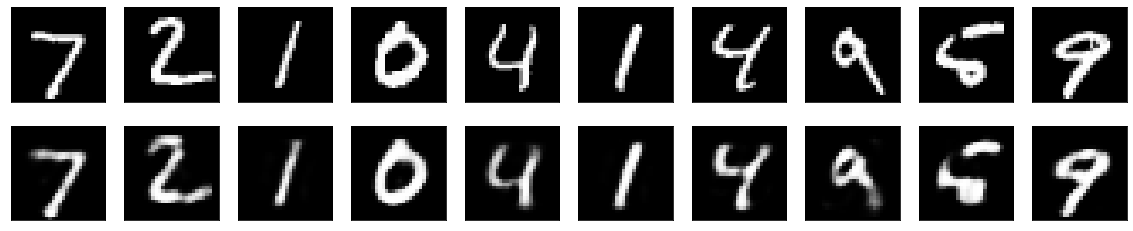

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
